In [296]:
import numpy as np
import pagn.constants as ct
import matplotlib.pyplot as plt
import pagn
import argparse
import imf

import NT_disk_Eqns_V1 as jscript
import binary_formation_distribution_V8 as myscript
import binary_formation_distribution_V11 as myscript2

from scipy.interpolate import UnivariateSpline

from os import makedirs
import os

import pandas as pd
import matplotlib.patches as patch

import powerlaw
import random

import Novikov
import Thompson_edited as edit
from scipy.interpolate import interp1d
from pagn.opacities import electron_scattering_opacity
#scontinuing on from disk_profiles.ipynb to generalise to some rate calculations

In [432]:
def T_align(disk, Mbh, mbh, cos_i, H, R):
    i=np.arccos(cos_i)
    cos_i2=np.cos(i/2)
    sin_i2=np.sin(i/2)
    t_orb=2*np.pi*(R)**(2/3) * (ct.G * Mbh)**(-1/2)
    t_align= (t_orb * Mbh**2)/(2*mbh*disk.Mdisk) * cos_i2 * (sin_i2**2 + H/(4*R))**2
    return t_align

def R_in(Mbh, mbh, T):
    M=Mbh+mbh
    Mm=Mbh*mbh

    a=(256/5 * (1/ct.c**5) * ct.G**3 * M * Mm * T)**(1/4)
    return a

def cluster_df(cluster, R, cos_i, disk):
    # print(f'cluster:{cluster}\n R:{R}\n cosi:{cos_i}\n disk:{disk}')
    Mbh=disk.Mbh

    R_g=Mbh * ct.G /(ct.c*ct.c)

    d = {"mbh [Msun]": cluster, 'r [Rg]': R/R_g, 'cos_i': cos_i}
    df=pd.DataFrame(data=d)

    f=interp1d(disk.R, disk.h, kind='linear', fill_value='extrapolate')
    h_clust=f(df['r [Rg]'] * R_g)

    df["H/R"]=h_clust/(df['r [Rg]'] * R_g)
    df['H']=h_clust

    mbh=df['mbh [Msun]']*ct.MSun

    t_align=T_align(disk, Mbh, mbh, df['cos_i'], df['H'], df['r [Rg]'])

    df['t_align [yrs]']=t_align/(365*24*60*60)

    p=1-np.exp((-(1e7*365*24*60*60)/(t_align)))
    df['p_align']=p

    return df

def cluster_sampling(MBH_digit, MBH_power, alpha, eps, spin, le, DT, BIMF, save):

    Mbh=Mbh=MBH_digit * 10**MBH_power * ct.MSun

    Ledd=jscript.Ledd(Mbh, X=0.7)
    Mdot_edd = Ledd / (eps*ct.c ** 2)
    Mdot = le * Mdot_edd

    # mdot=Mdot/Mdot_edd
    # print(mdot)

    if DT=="SG":
        disk = pagn.SirkoAGN(Mbh=Mbh, alpha=alpha, le=le, eps=eps)
        # disk = pagn.SirkoAGN(Mbh=Mbh)
        Rmin = disk.Rmin
        Rmax = disk.Rmax
        disk.solve_disk()

    R_g=Mbh * ct.G /(ct.c*ct.c)

    cluster=[]
    cluster_mass=2 * Mbh/ct.MSun

    if BIMF=='Tagawa':
    #Tagawa et al 2020 BIMF
        cluster_tagawa = imf.make_cluster(cluster_mass, massfunc='salpeter', alpha=2.3, mmin=0.1, mmax=140)
        for mass in cluster_tagawa:
            if mass<20:
                continue
            elif 20<=mass<40:
                mass_bh=mass/4
            elif 40<=mass<=55:
                mass_bh=10
            elif 55<=mass<=120:
                mass_bh=mass/13 + 5.77
            else:
                mass_bh=15
            cluster.append(mass_bh)
        bh_mass_tot=np.sum(cluster)
        print(f'Total bh mass is {bh_mass_tot}')

    elif BIMF=='Bartos':
    #Bartos et al 2017 BIMF
        bartos_cluster=imf.make_cluster(0.04*cluster_mass, massfunc='salpeter', alpha=2, mmin=5, mmax=50)
        cluster=bartos_cluster
        print(f'Total bh mass is {np.sum(cluster)}')

    elif BIMF=='Vaccaro':
    #Actually from Iorio et al 2023, but file provided by MP Vaccaro
        mass_tot=0
        mass_sec=np.genfromtxt("BHs_single_Zsun_rapid_nospin.dat",usecols=(0),skip_header=3,unpack=True)
        while mass_tot<0.04*cluster_mass:
            c = np.random.randint(0, len(mass_sec))
            cluster.append(mass_sec[c])
            mass_tot+=mass_sec[c]
        print(f'Total bh mass is {np.sum(cluster)}')

    T=14 * 10**9 * ct.yr

    Rmax=0.1 * jscript.pc * (Mbh/(1e6 * ct.MSun))**(1/2)
    # R_min=1e-4*jscript.pc

    R_min=R_in(Mbh, np.mean(cluster)*ct.MSun, T)
    print(f'Rmin: {R_min/ct.pc} pc, Rmax: {Rmax/ct.pc} pc')
    a=powerlaw.Power_Law(alpha=2.5, xmin=R_min, xmax=Rmax)
        # print(np.max(a.rvs(len(iorio_bhs))))
    R=a.generate_random(len(cluster))

    cos_i=np.random.uniform(-1.0, 1.0, len(cluster))
    df=cluster_df(cluster, R, cos_i, disk)

    if save==True:
        df.to_csv(f'EMRI_Rates/{BIMF}/dataframes/{DT}_{MBH_digit}e{MBH_power}_alpha_{alpha}_eps_{eps}_le_{le}_spin_{spin}_improved_Rin.csv')
    return df

def plot_cluster(df, MBH_digit, MBH_power, alpha, eps, le, spin, BIMF, t_agn, DT, save=False):
    plt.figure(figsize=(6, 8))
    plt.scatter(df['r [Rg]'], df['mbh [Msun]'], c=df['t_align [yrs]']/t_agn, cmap='gist_rainbow', norm='log')
    plt.xscale('log')
    plt.colorbar(label="$t_{align}/t_{AGN}$", orientation="horizontal")
    # plt.clim(0,1)
    plt.xscale('log')
    plt.xlabel(r'$R~[R_g]$')
    plt.ylabel(r'$mbh~[M_{\odot}]$')
    plt.title('$t_{align}/t_{AGN},~$' f'SMBH={MBH_digit}e{MBH_power}'r'$M_{\odot}, ~\alpha$' f'$={alpha},~e={eps},~l_e={le},~X={spin}$')
    if save==True:
        plt.savefig(f'EMRI_Rates/{BIMF}/t_align_{DT}_{MBH_digit}e{MBH_power}_alpha_{alpha}_eps_{eps}_le_{le}_spin_{spin}.png')
    plt.show()

    plt.figure(figsize=(6, 8))
    plt.scatter(df['r [Rg]'], df['mbh [Msun]'], c=df['p_align'], cmap='gist_rainbow')
    plt.xscale('log')
    plt.colorbar(label="$p_{align}$", orientation="horizontal")
    plt.clim(0,1)
    plt.xscale('log')
    plt.xlabel(r'$R~[R_g]$')
    plt.ylabel(r'$mbh~[M_{\odot}]$')
    plt.title('$p_{align},~$' f'SMBH={MBH_digit}e{MBH_power}'r'$M_{\odot}, ~\alpha$' f'$={alpha},~e={eps},~l_e={le},~X={spin}$')
    if save==True:
        plt.savefig(f'EMRI_Rates/{BIMF}/p_align_{DT}_{MBH_digit}e{MBH_power}_alpha_{alpha}_eps_{eps}_le_{le}_spin_{spin}.png')
    plt.show()


1e4 MSun, alpha 0.01, BIMF Tagawa
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+04 MSun
Mdot = 2.596689e-06 MSun/yr
le = 0.01
Rs = 9.570121e-10 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-03 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=9405 (R=4.27e+06 Rs)
Beginning star formation at index 9405
Mdisk = 231.40507861367183 Msun
Mdisk/Mbh = 0.023140507861367184
Total cluster mass is 20000.3 (limit was 20000)
Total bh mass is 350.7255306280309
Rmin: 1.1910155070805766e-05 pc, Rmax: 0.01 pc


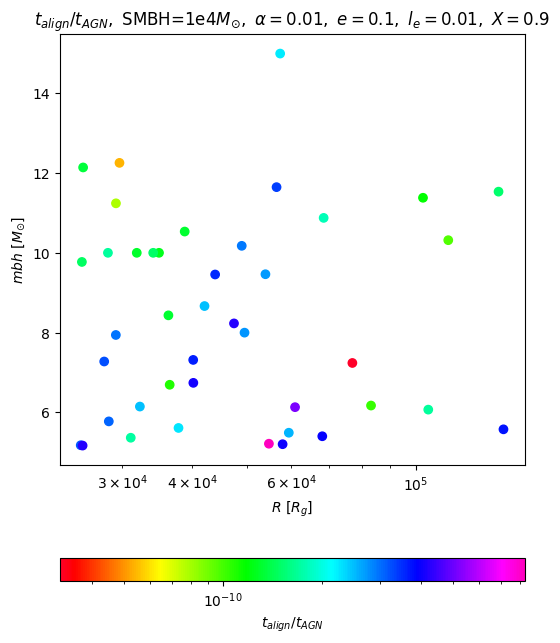

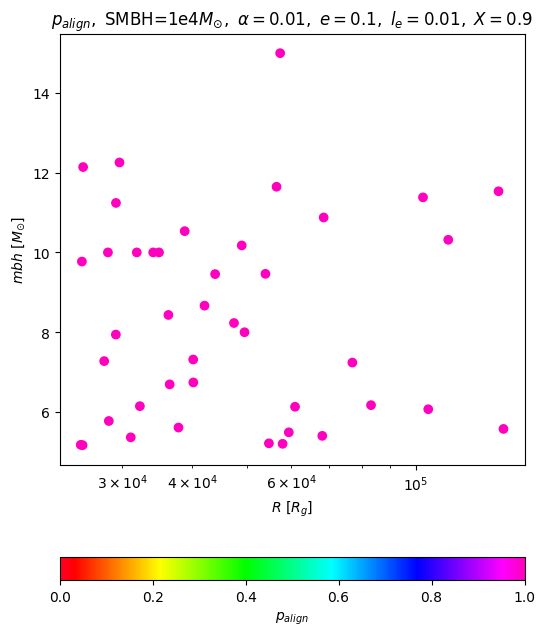

1e4 MSun, alpha 0.01, BIMF Bartos
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+04 MSun
Mdot = 2.596689e-06 MSun/yr
le = 0.01
Rs = 9.570121e-10 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-03 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=9405 (R=4.27e+06 Rs)
Beginning star formation at index 9405
Mdisk = 231.40507861367183 Msun
Mdisk/Mbh = 0.023140507861367184
Total cluster mass is 798.637 (limit was 800)
Total bh mass is 798.6366914988151
Rmin: 1.32747522443177e-05 pc, Rmax: 0.01 pc


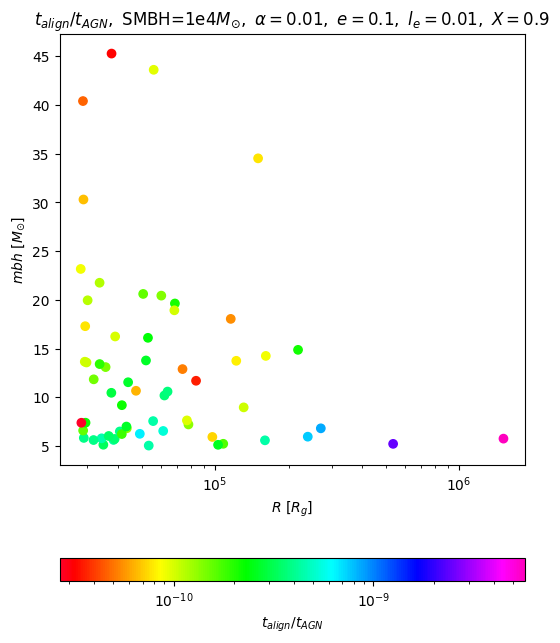

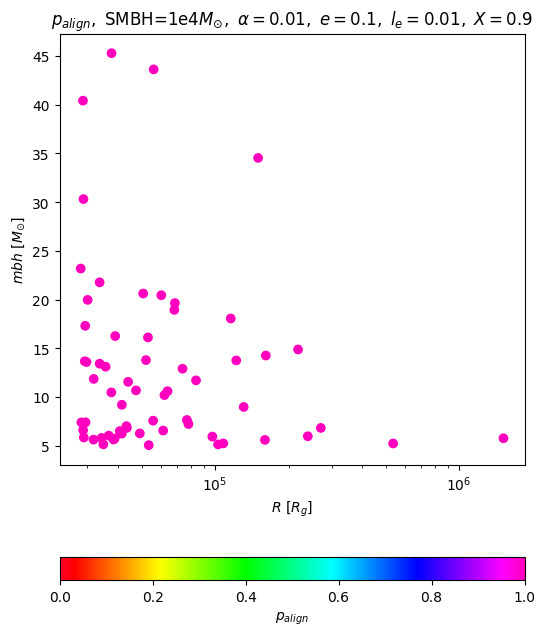

1e4 MSun, alpha 0.01, BIMF Vaccaro
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+04 MSun
Mdot = 2.596689e-06 MSun/yr
le = 0.01
Rs = 9.570121e-10 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-03 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=9405 (R=4.27e+06 Rs)
Beginning star formation at index 9405
Mdisk = 231.40507861367183 Msun
Mdisk/Mbh = 0.023140507861367184
Total bh mass is 803.0103257753999
Rmin: 1.3402473214904245e-05 pc, Rmax: 0.01 pc


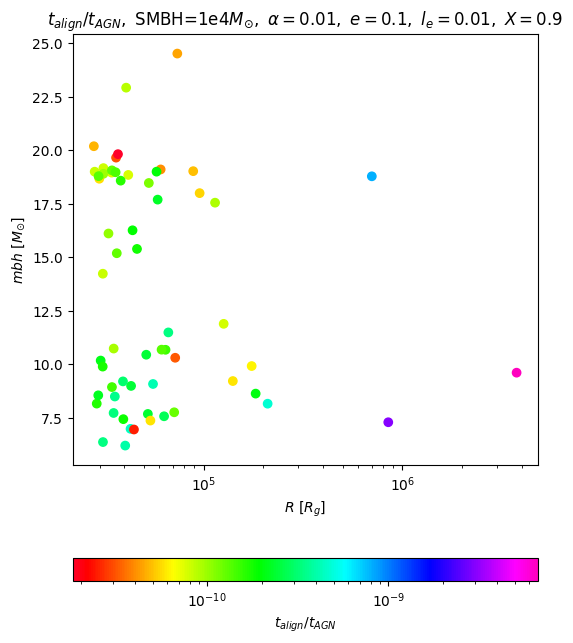

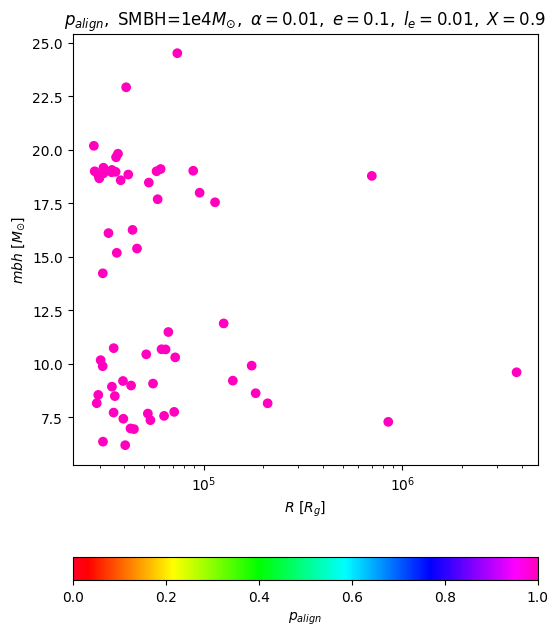

1e4 MSun, alpha 0.1, BIMF Tagawa
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+04 MSun
Mdot = 2.596689e-06 MSun/yr
le = 0.01
Rs = 9.570121e-10 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-03 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=9911 (R=8.81e+06 Rs)
Beginning star formation at index 9911
Mdisk = 68.494617692542 Msun
Mdisk/Mbh = 0.0068494617692542
Total cluster mass is 19999.9 (limit was 20000)
Total bh mass is 443.02104995718395
Rmin: 1.1857522421152947e-05 pc, Rmax: 0.01 pc


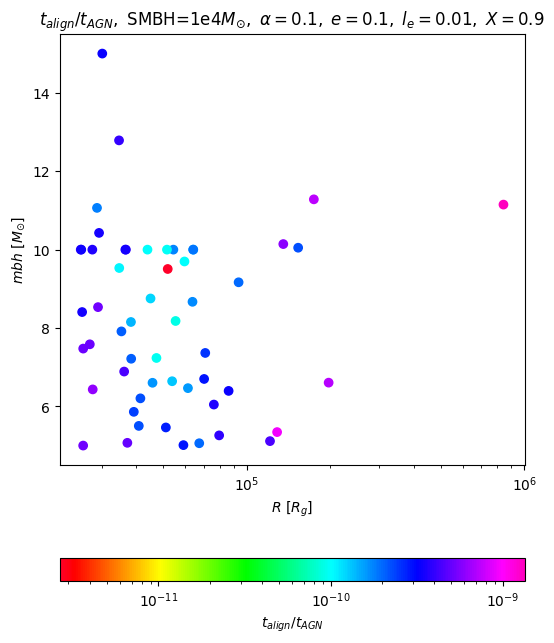

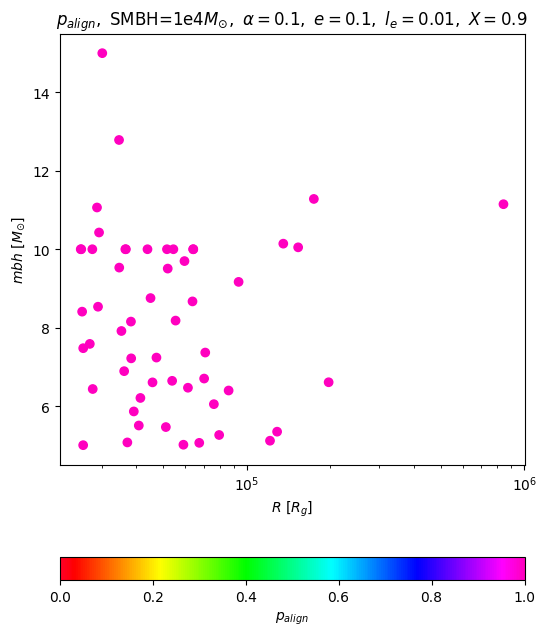

1e4 MSun, alpha 0.1, BIMF Bartos
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+04 MSun
Mdot = 2.596689e-06 MSun/yr
le = 0.01
Rs = 9.570121e-10 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-03 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=9911 (R=8.81e+06 Rs)
Beginning star formation at index 9911
Mdisk = 68.494617692542 Msun
Mdisk/Mbh = 0.0068494617692542
Total cluster mass is 798.728 (limit was 800)
Total bh mass is 798.7278330781035
Rmin: 1.3617729767895162e-05 pc, Rmax: 0.01 pc


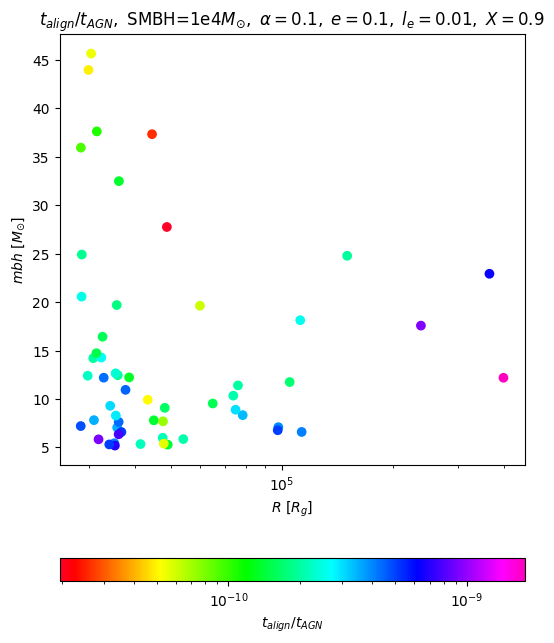

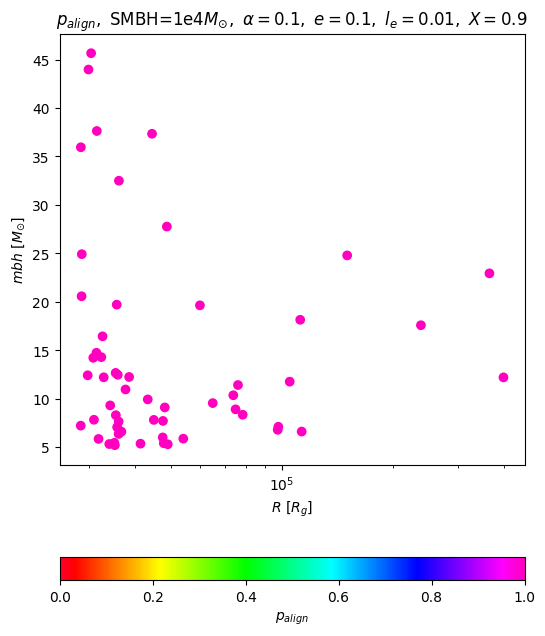

1e4 MSun, alpha 0.1, BIMF Vaccaro
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+04 MSun
Mdot = 2.596689e-06 MSun/yr
le = 0.01
Rs = 9.570121e-10 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-03 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=9911 (R=8.81e+06 Rs)
Beginning star formation at index 9911
Mdisk = 68.494617692542 Msun
Mdisk/Mbh = 0.0068494617692542
Total bh mass is 802.8064343935
Rmin: 1.3401621245431015e-05 pc, Rmax: 0.01 pc


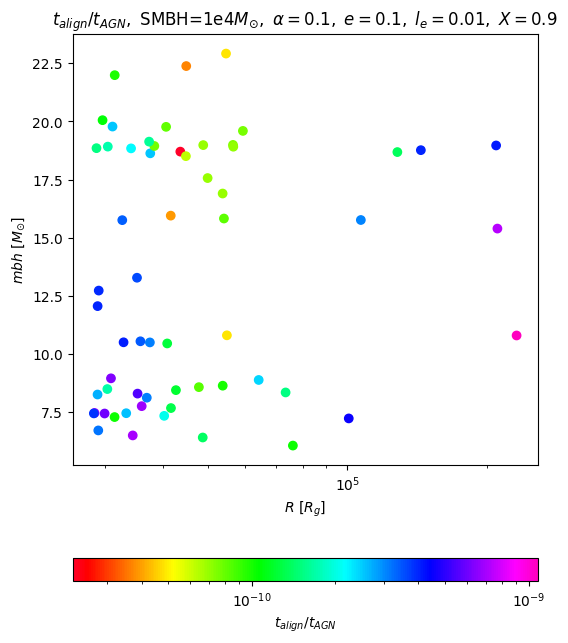

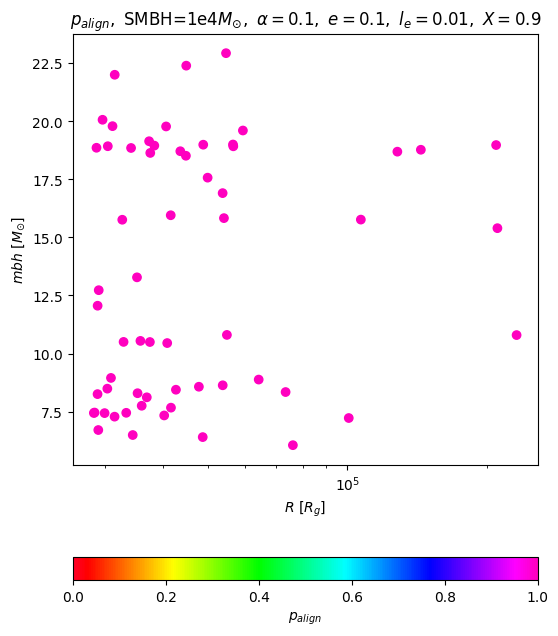

1e5 MSun, alpha 0.01, BIMF Tagawa
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+05 MSun
Mdot = 2.596689e-05 MSun/yr
le = 0.01
Rs = 9.570121e-09 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-02 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=8099 (R=6.57e+05 Rs)
Beginning star formation at index 8099
Mdisk = 7742.982403955666 Msun
Mdisk/Mbh = 0.07742982403955666
Total cluster mass is 200000 (limit was 200000)
Total bh mass is 4290.461562950642
Rmin: 3.7561281877860105e-05 pc, Rmax: 0.03162277660168379 pc


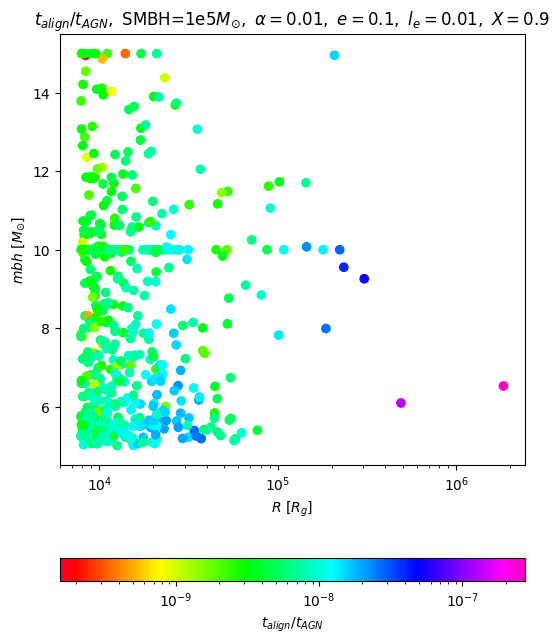

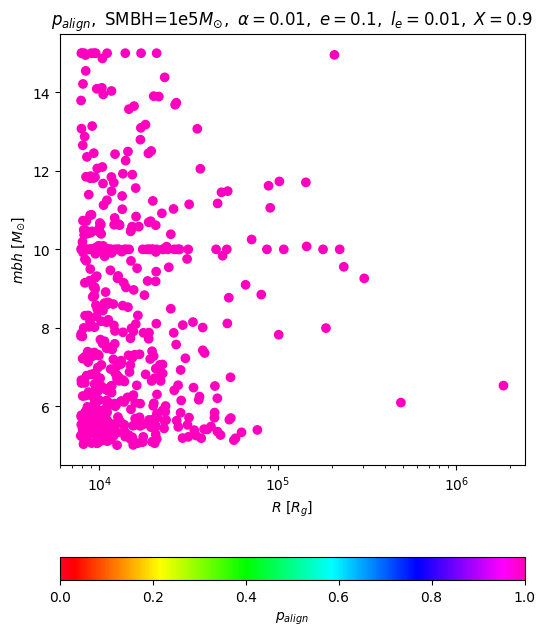

1e5 MSun, alpha 0.01, BIMF Bartos
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+05 MSun
Mdot = 2.596689e-05 MSun/yr
le = 0.01
Rs = 9.570121e-09 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-02 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=8099 (R=6.57e+05 Rs)
Beginning star formation at index 8099
Mdisk = 7742.982403955666 Msun
Mdisk/Mbh = 0.07742982403955666
Total cluster mass is 7999.78 (limit was 8000)
Total bh mass is 7999.779802716899
Rmin: 4.2154947524414605e-05 pc, Rmax: 0.03162277660168379 pc


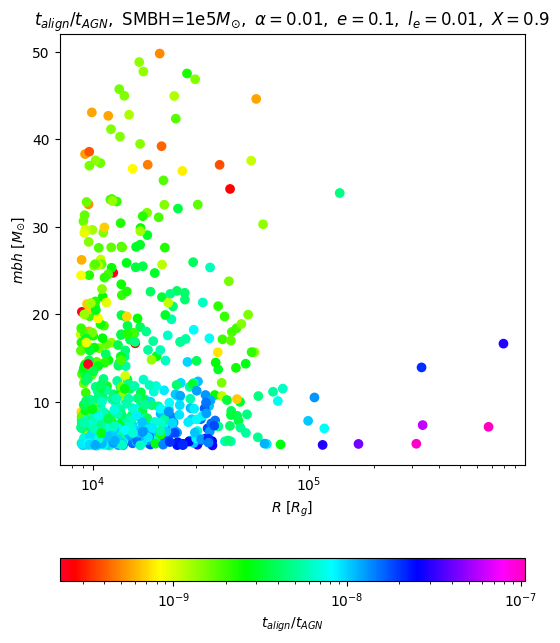

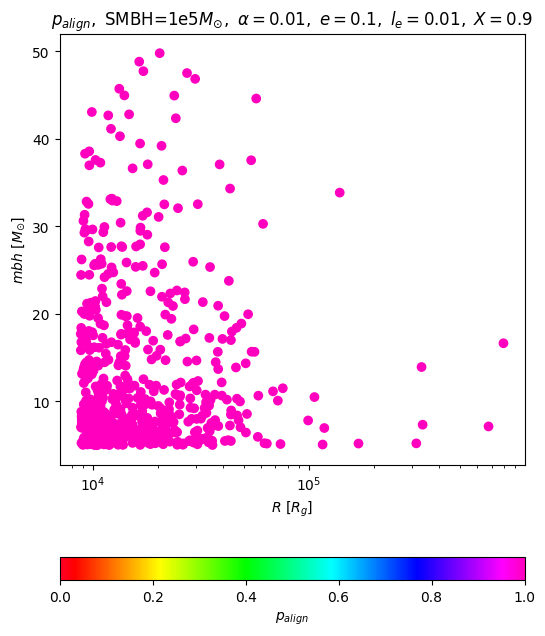

1e5 MSun, alpha 0.01, BIMF Vaccaro
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+05 MSun
Mdot = 2.596689e-05 MSun/yr
le = 0.01
Rs = 9.570121e-09 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-02 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=8099 (R=6.57e+05 Rs)
Beginning star formation at index 8099
Mdisk = 7742.982403955666 Msun
Mdisk/Mbh = 0.07742982403955666
Total bh mass is 8009.6631057362
Rmin: 4.2611490556298154e-05 pc, Rmax: 0.03162277660168379 pc


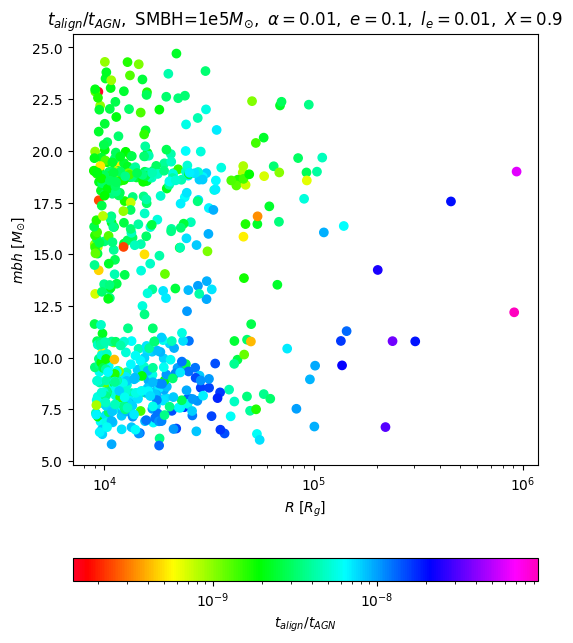

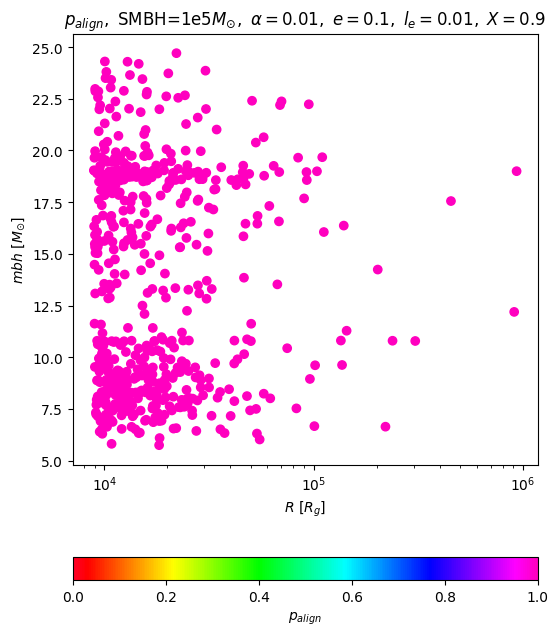

1e5 MSun, alpha 0.1, BIMF Tagawa
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+05 MSun
Mdot = 2.596689e-05 MSun/yr
le = 0.01
Rs = 9.570121e-09 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-02 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=8692 (R=1.54e+06 Rs)
Beginning star formation at index 8692
Mdisk = 3093.761102781169 Msun
Mdisk/Mbh = 0.030937611027811694
Total cluster mass is 200000 (limit was 200000)
Total bh mass is 4131.517360900551
Rmin: 3.786365971564221e-05 pc, Rmax: 0.03162277660168379 pc


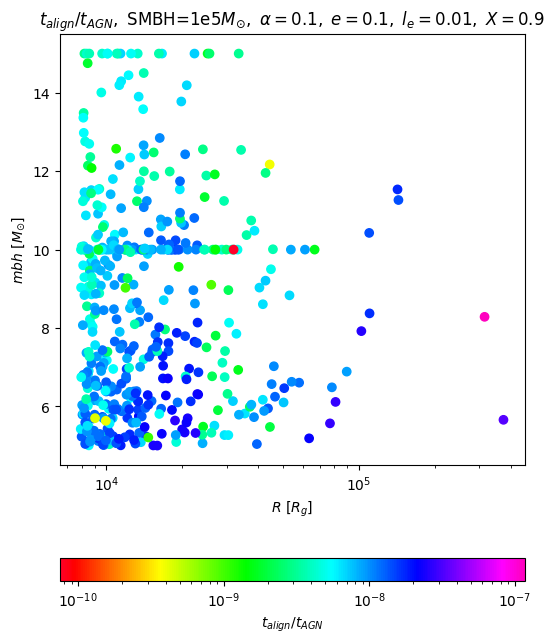

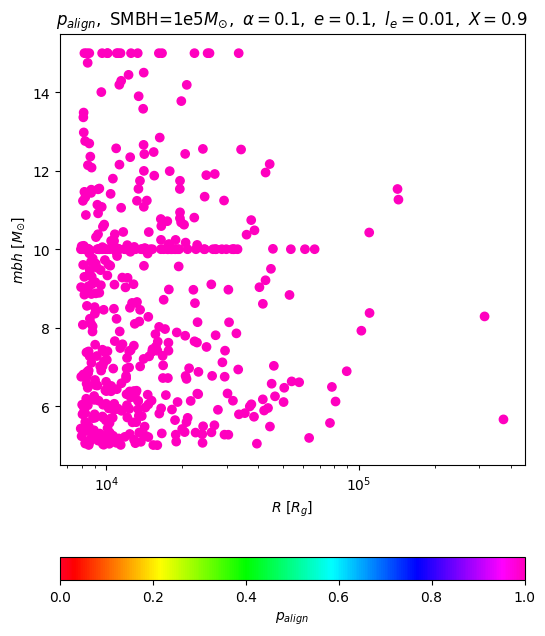

1e5 MSun, alpha 0.1, BIMF Bartos
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+05 MSun
Mdot = 2.596689e-05 MSun/yr
le = 0.01
Rs = 9.570121e-09 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-02 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=8692 (R=1.54e+06 Rs)
Beginning star formation at index 8692
Mdisk = 3093.761102781169 Msun
Mdisk/Mbh = 0.030937611027811694
Total cluster mass is 7997.92 (limit was 8000)
Total bh mass is 7997.922574510201
Rmin: 4.2327071686926045e-05 pc, Rmax: 0.03162277660168379 pc


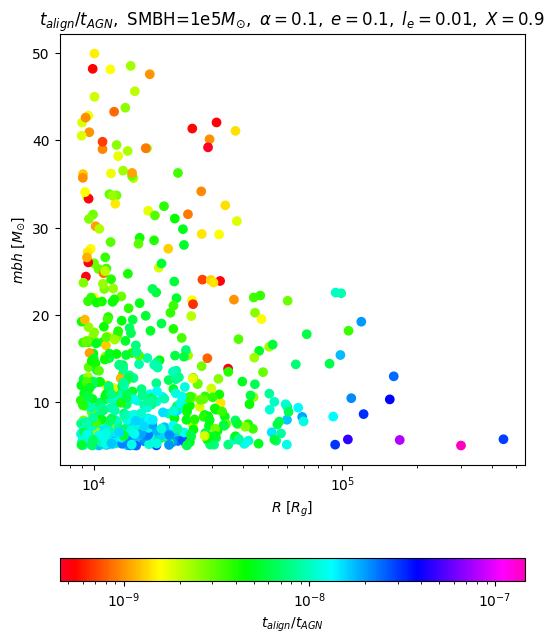

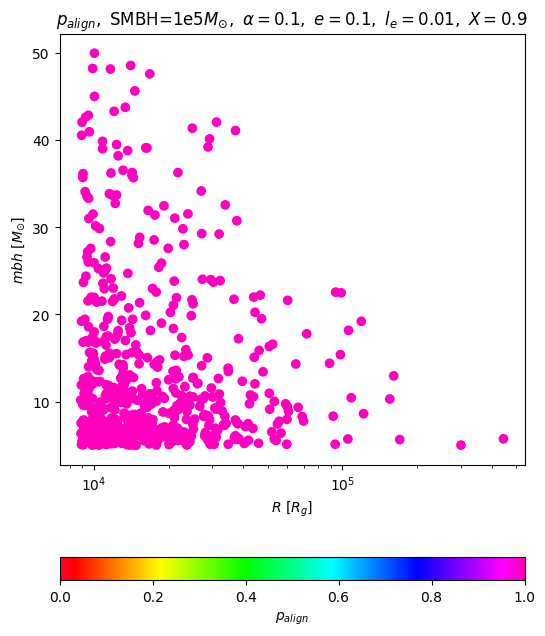

1e5 MSun, alpha 0.1, BIMF Vaccaro
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+05 MSun
Mdot = 2.596689e-05 MSun/yr
le = 0.01
Rs = 9.570121e-09 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-02 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=8692 (R=1.54e+06 Rs)
Beginning star formation at index 8692
Mdisk = 3093.761102781169 Msun
Mdisk/Mbh = 0.030937611027811694
Total bh mass is 8003.4308710972
Rmin: 4.2824551545867126e-05 pc, Rmax: 0.03162277660168379 pc


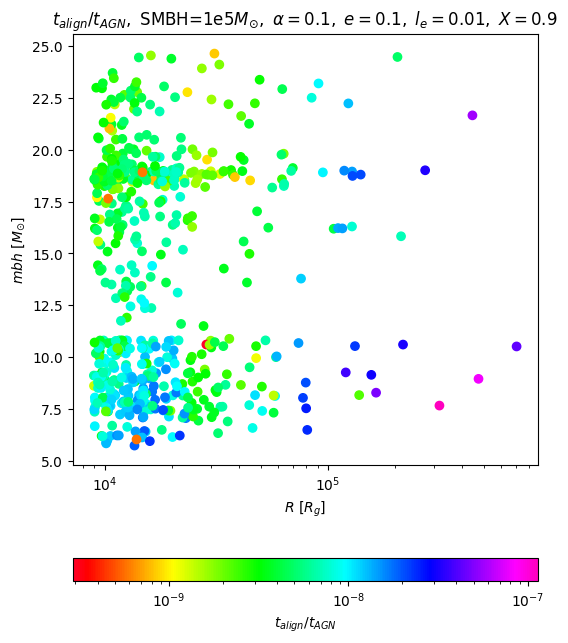

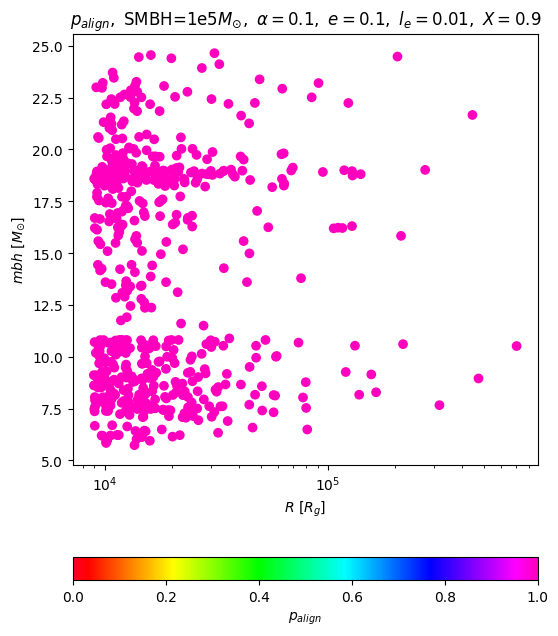

1e6 MSun, alpha 0.01, BIMF Tagawa
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+06 MSun
Mdot = 2.596689e-04 MSun/yr
le = 0.01
Rs = 9.570121e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-01 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5536 (R=1.67e+04 Rs)
Beginning star formation at index 5536
Mdisk = 191086.96411882318 Msun
Mdisk/Mbh = 0.1910869641188232
Total cluster mass is 2e+06 (limit was 2e+06)
Total bh mass is 41226.25754716389
Rmin: 0.0001189921786503653 pc, Rmax: 0.1 pc


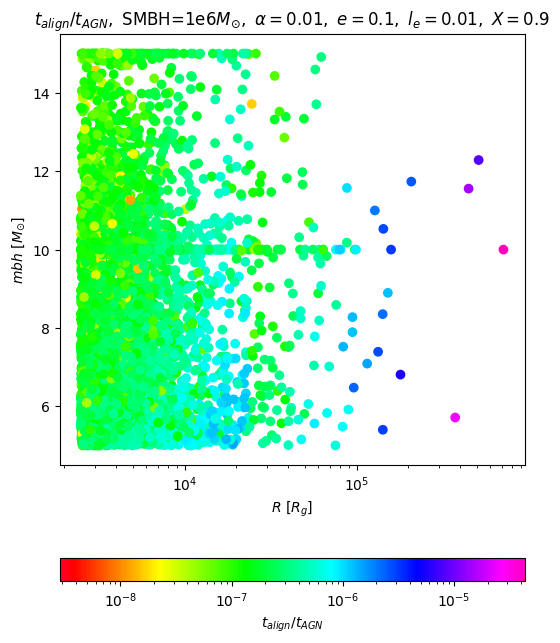

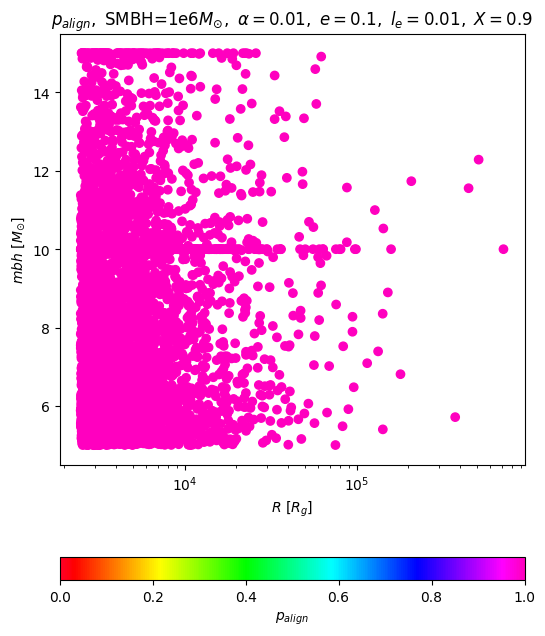

1e6 MSun, alpha 0.01, BIMF Bartos
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+06 MSun
Mdot = 2.596689e-04 MSun/yr
le = 0.01
Rs = 9.570121e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-01 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5536 (R=1.67e+04 Rs)
Beginning star formation at index 5536
Mdisk = 191086.96411882318 Msun
Mdisk/Mbh = 0.1910869641188232
Total cluster mass is 79999 (limit was 80000)
Total bh mass is 79998.98385827278
Rmin: 0.00013203275793823615 pc, Rmax: 0.1 pc


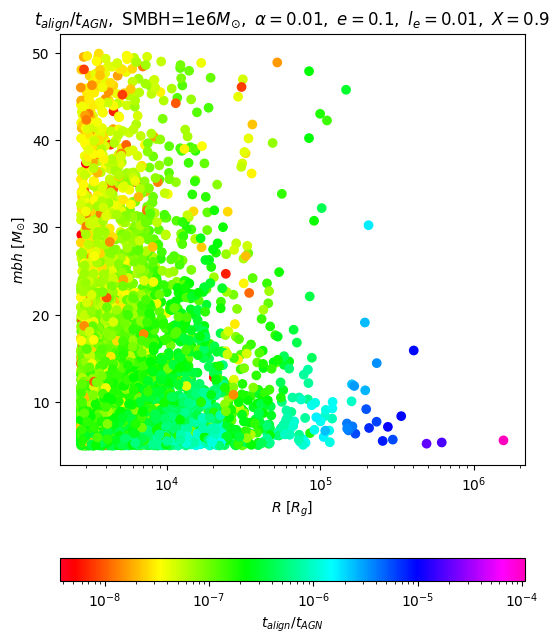

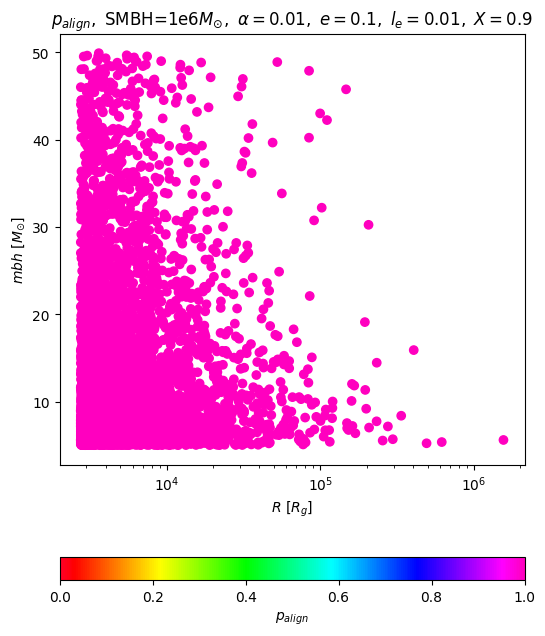

1e6 MSun, alpha 0.01, BIMF Vaccaro
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+06 MSun
Mdot = 2.596689e-04 MSun/yr
le = 0.01
Rs = 9.570121e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-01 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5536 (R=1.67e+04 Rs)
Beginning star formation at index 5536
Mdisk = 191086.96411882318 Msun
Mdisk/Mbh = 0.1910869641188232
Total bh mass is 80005.3231280689
Rmin: 0.00013453464352812503 pc, Rmax: 0.1 pc


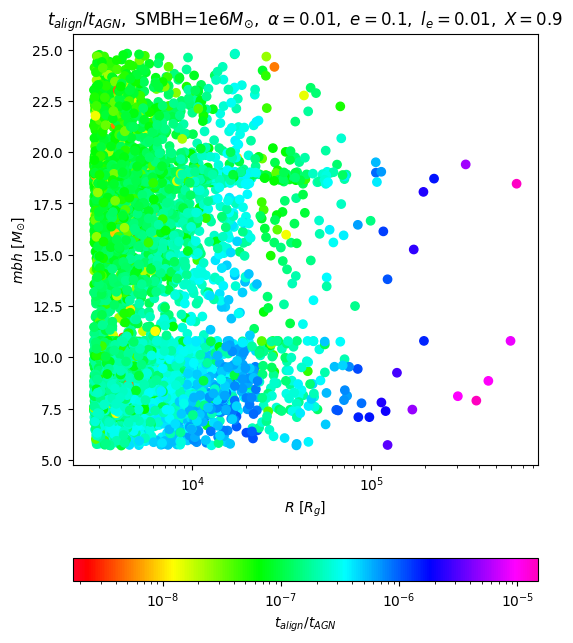

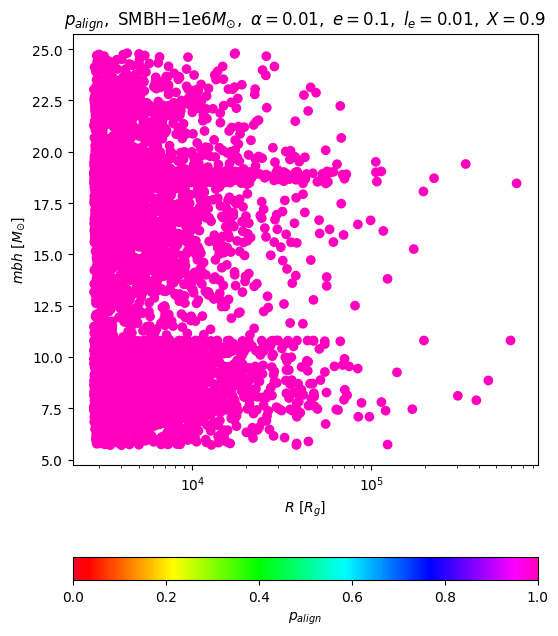

1e6 MSun, alpha 0.1, BIMF Tagawa
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+06 MSun
Mdot = 2.596689e-04 MSun/yr
le = 0.01
Rs = 9.570121e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-01 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=7386 (R=2.37e+05 Rs)
Beginning star formation at index 7386
Mdisk = 83180.73756592847 Msun
Mdisk/Mbh = 0.08318073756592848
Total cluster mass is 2e+06 (limit was 2e+06)
Total bh mass is 40943.44800346603
Rmin: 0.0001188897691331391 pc, Rmax: 0.1 pc


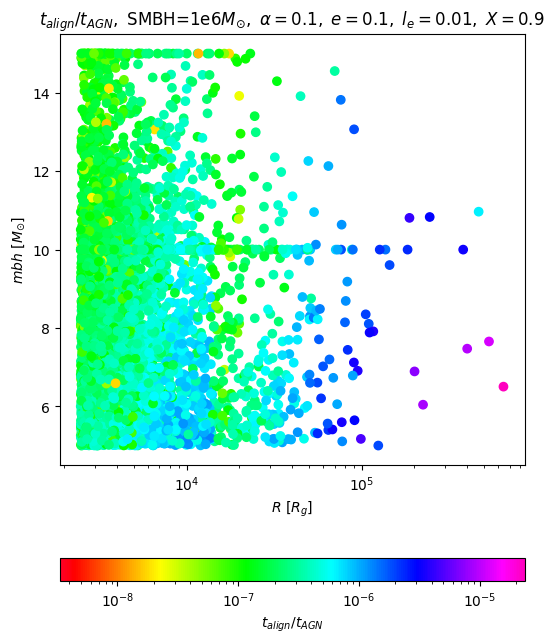

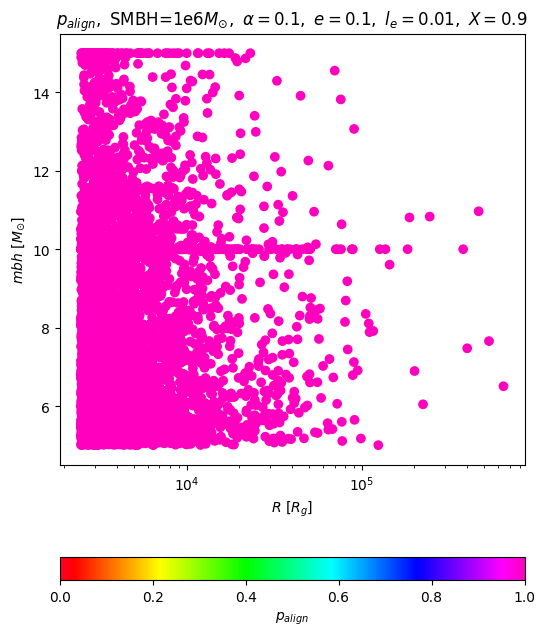

1e6 MSun, alpha 0.1, BIMF Bartos
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+06 MSun
Mdot = 2.596689e-04 MSun/yr
le = 0.01
Rs = 9.570121e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-01 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=7386 (R=2.37e+05 Rs)
Beginning star formation at index 7386
Mdisk = 83180.73756592847 Msun
Mdisk/Mbh = 0.08318073756592848
Total cluster mass is 80003.9 (limit was 80000)
Total bh mass is 80003.91364038174
Rmin: 0.0001327795221673103 pc, Rmax: 0.1 pc


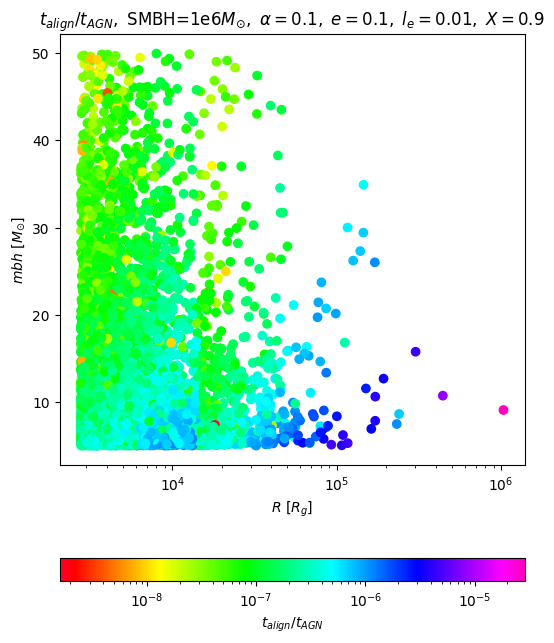

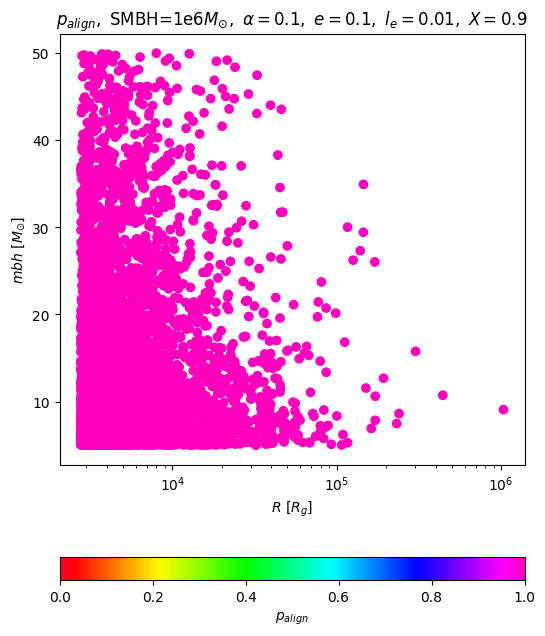

1e6 MSun, alpha 0.1, BIMF Vaccaro
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+06 MSun
Mdot = 2.596689e-04 MSun/yr
le = 0.01
Rs = 9.570121e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-01 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=7386 (R=2.37e+05 Rs)
Beginning star formation at index 7386
Mdisk = 83180.73756592847 Msun
Mdisk/Mbh = 0.08318073756592848
Total bh mass is 80000.60521577101
Rmin: 0.00013437866168972232 pc, Rmax: 0.1 pc


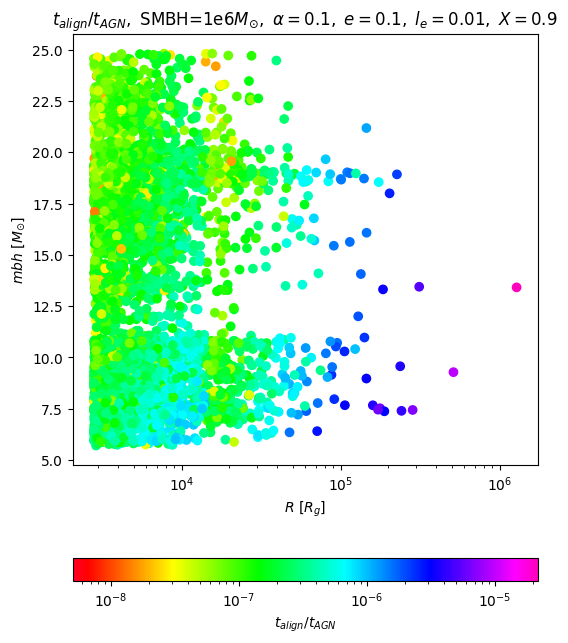

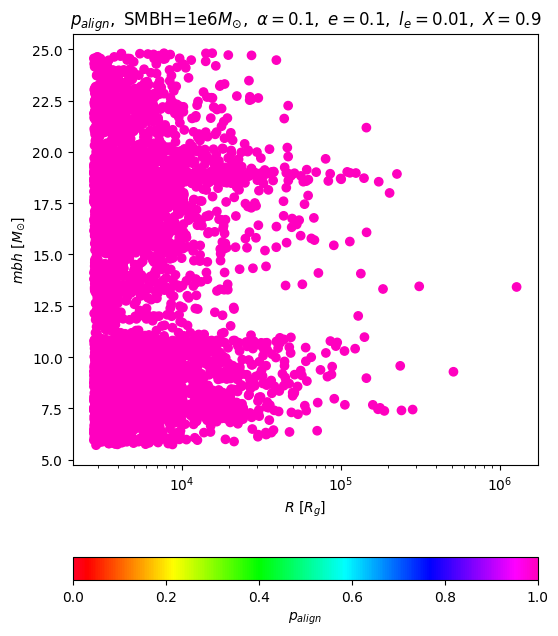

1e7 MSun, alpha 0.01, BIMF Tagawa
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+07 MSun
Mdot = 2.596689e-03 MSun/yr
le = 0.01
Rs = 9.570121e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+00 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=4933 (R=7.04e+03 Rs)
Beginning star formation at index 4933
Mdisk = 4176389.3610795643 Msun
Mdisk/Mbh = 0.41763893610795644
Total cluster mass is 2e+07 (limit was 2e+07)
Total bh mass is 412687.0407589308
Rmin: 0.0003768954100205222 pc, Rmax: 0.316227766016838 pc


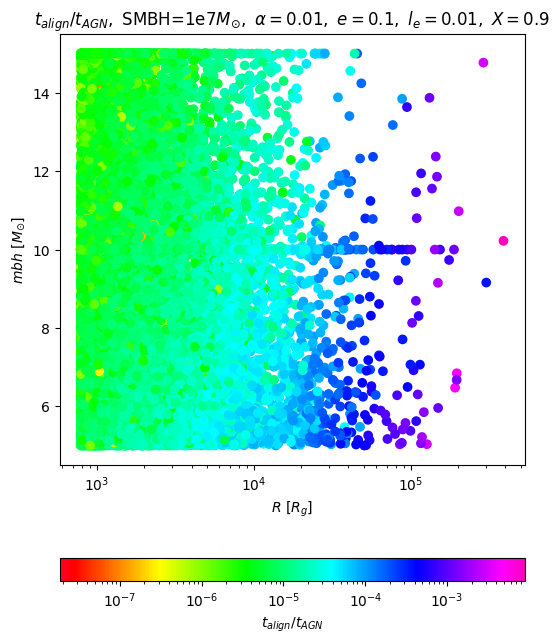

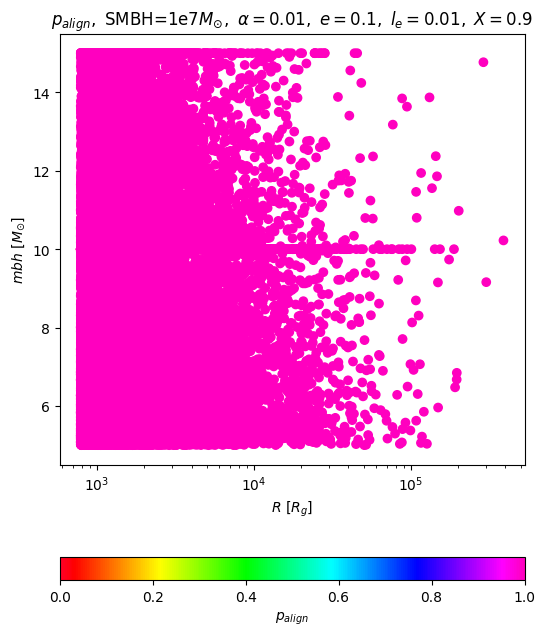

1e7 MSun, alpha 0.01, BIMF Bartos
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+07 MSun
Mdot = 2.596689e-03 MSun/yr
le = 0.01
Rs = 9.570121e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+00 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=4933 (R=7.04e+03 Rs)
Beginning star formation at index 4933
Mdisk = 4176389.3610795643 Msun
Mdisk/Mbh = 0.41763893610795644
Total cluster mass is 799994 (limit was 800000)
Total bh mass is 799993.8470266549
Rmin: 0.0004186760887624133 pc, Rmax: 0.316227766016838 pc


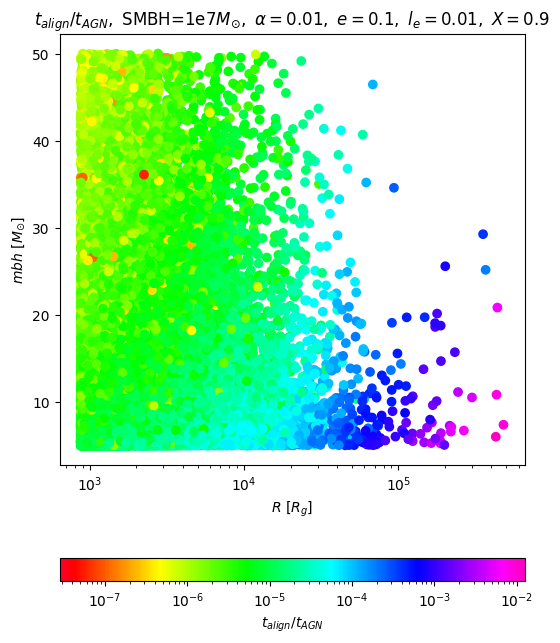

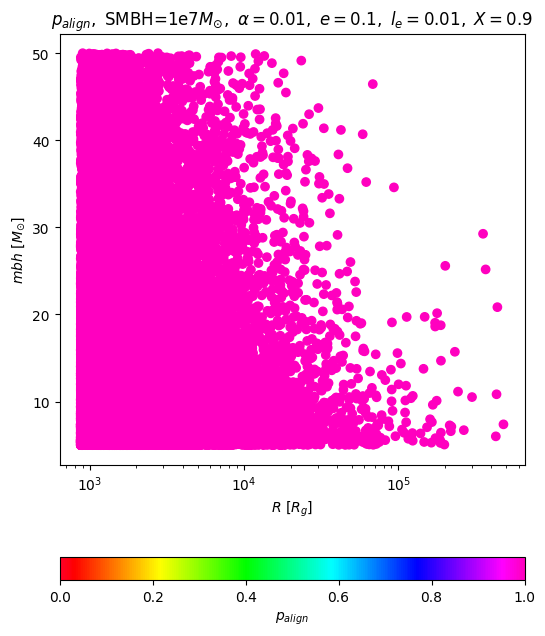

1e7 MSun, alpha 0.01, BIMF Vaccaro
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+07 MSun
Mdot = 2.596689e-03 MSun/yr
le = 0.01
Rs = 9.570121e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+00 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=4933 (R=7.04e+03 Rs)
Beginning star formation at index 4933
Mdisk = 4176389.3610795643 Msun
Mdisk/Mbh = 0.41763893610795644
Total bh mass is 800007.4777887387
Rmin: 0.0004248336946311758 pc, Rmax: 0.316227766016838 pc


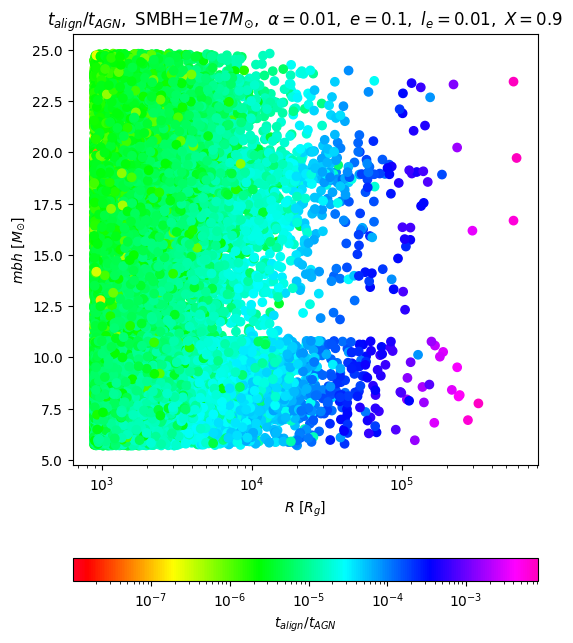

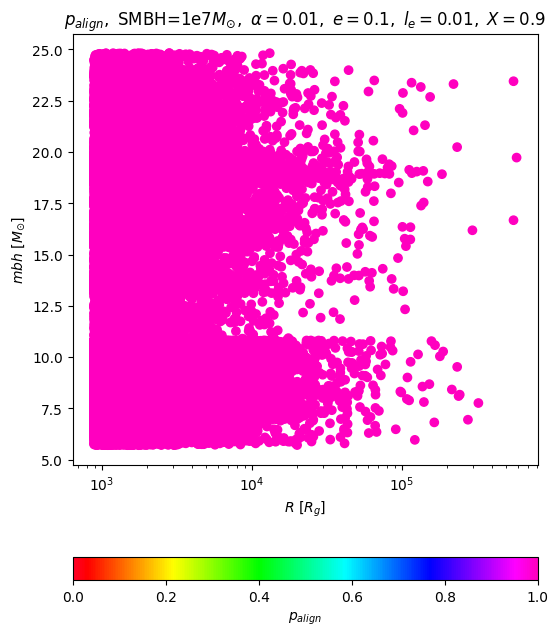

1e7 MSun, alpha 0.1, BIMF Tagawa
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+07 MSun
Mdot = 2.596689e-03 MSun/yr
le = 0.01
Rs = 9.570121e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+00 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5179 (R=1.00e+04 Rs)
Beginning star formation at index 5179
Mdisk = 1934601.164096946 Msun
Mdisk/Mbh = 0.1934601164096946
Total cluster mass is 2e+07 (limit was 2e+07)
Total bh mass is 406478.1349107375
Rmin: 0.0003770649419938872 pc, Rmax: 0.316227766016838 pc


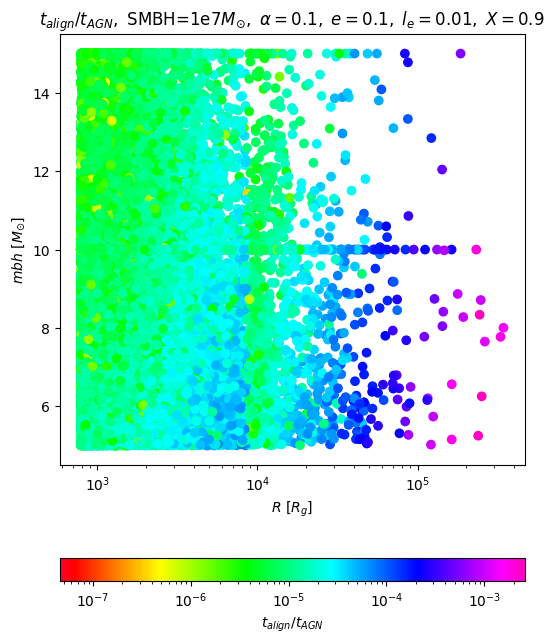

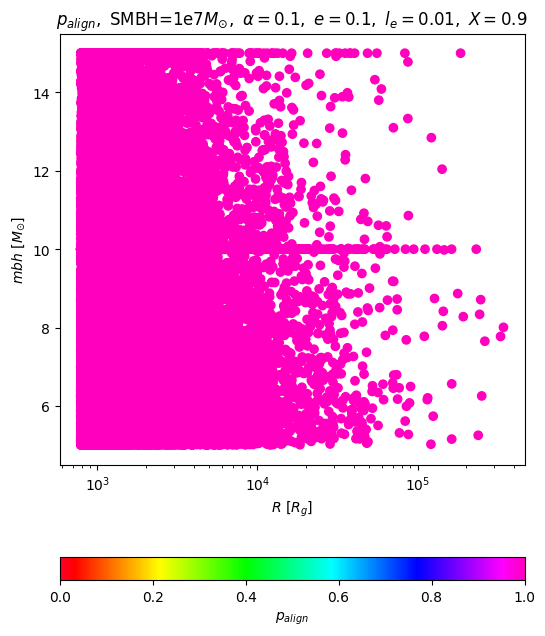

1e7 MSun, alpha 0.1, BIMF Bartos
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+07 MSun
Mdot = 2.596689e-03 MSun/yr
le = 0.01
Rs = 9.570121e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+00 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5179 (R=1.00e+04 Rs)
Beginning star formation at index 5179
Mdisk = 1934601.164096946 Msun
Mdisk/Mbh = 0.1934601164096946
Total cluster mass is 800005 (limit was 800000)
Total bh mass is 800004.8536937373
Rmin: 0.0004186191072843513 pc, Rmax: 0.316227766016838 pc


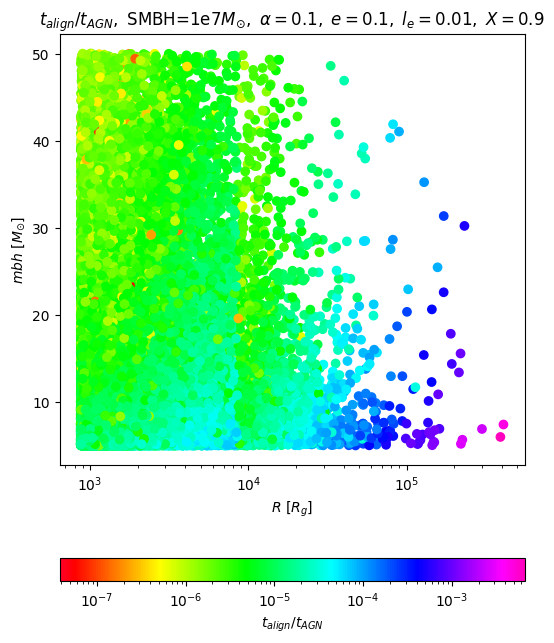

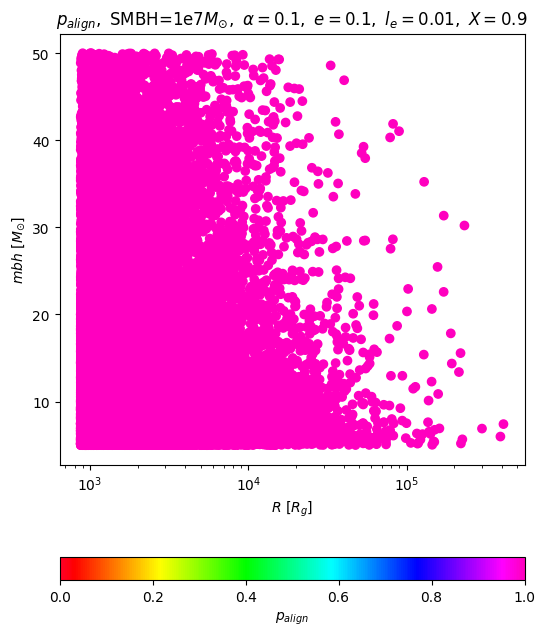

1e7 MSun, alpha 0.1, BIMF Vaccaro
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+07 MSun
Mdot = 2.596689e-03 MSun/yr
le = 0.01
Rs = 9.570121e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+00 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5179 (R=1.00e+04 Rs)
Beginning star formation at index 5179
Mdisk = 1934601.164096946 Msun
Mdisk/Mbh = 0.1934601164096946
Total bh mass is 800008.225517745
Rmin: 0.000425031604618162 pc, Rmax: 0.316227766016838 pc


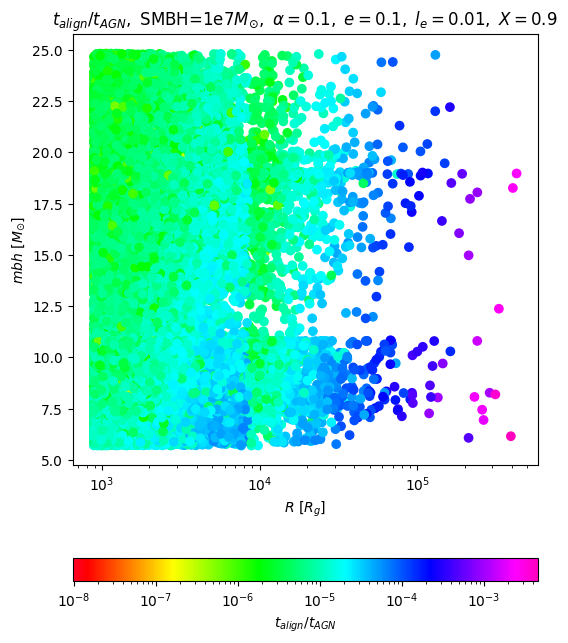

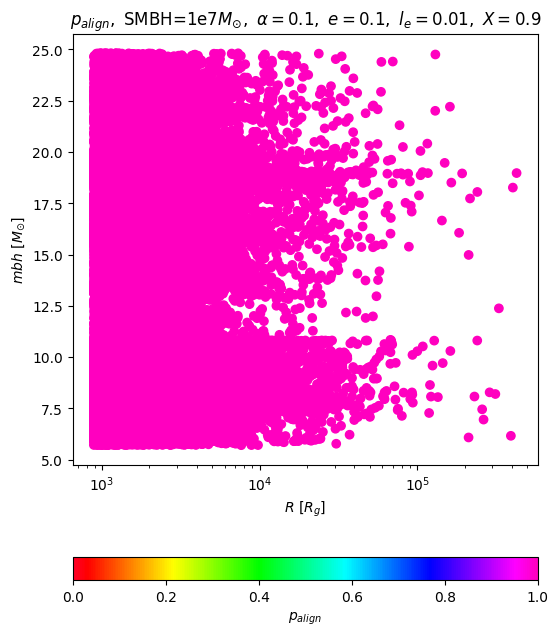

In [433]:
powers = 4,5,6,7
alphas = 0.01, 0.1
BIMFs='Tagawa', 'Bartos', 'Vaccaro'

spin=0.9
alpha=0.1
eps=0.1
le=0.01
t_agn=10**7
MBH_digit=1

TT='G23'
DT='SG'

for MBH_power in powers:
    for alpha in alphas:
        for BIMF in BIMFs:
            print(f'{MBH_digit}e{MBH_power} MSun, alpha {alpha}, BIMF {BIMF}')
            df=cluster_sampling(MBH_digit, MBH_power, alpha, eps, spin, le, DT, BIMF, True)
            plot_cluster(df, MBH_digit, MBH_power, alpha, eps, le, spin, BIMF, t_agn, DT, save=True)

In [332]:
mass_sec=np.genfromtxt("BHs_single_Zsun_rapid_nospin.dat",usecols=(0),skip_header=3,unpack=True)
print(mass_sec)
mass_sum=np.sum(mass_sec)

a=2.3

cluster=[]

cluster_tagawa = imf.make_cluster(mass_sum/0.04, massfunc='salpeter', alpha=a, mmin=0.1, mmax=140)
for mass in cluster_tagawa:
            if mass<20:
                continue
            elif 20<=mass<40:
                mass_bh=mass/4
            elif 40<=mass<=55:
                mass_bh=10
            elif 55<=mass<=120:
                mass_bh=mass/13 + 5.77
            else:
                mass_bh=15
            cluster.append(mass_bh)

with open(f"BHs_Tagawa_exp_{a}.dat", "w") as f:
    for line in cluster:
        f.write(f'{line}\n')

[18.86667817  7.46870859 18.77510559 ... 18.86833791 21.20454226
 16.52108277]
Total cluster mass is 1.49051e+07 (limit was 1.49051e+07)


In [333]:
mass_sec=np.genfromtxt(f"BHs_Tagawa_exp_{a}.dat",usecols=(0),skip_header=3,unpack=True)

print(mass_sec)

[12.81105952  5.76098667  7.35521767 ...  5.63726928  5.46887606
 10.29649732]


1e4 MSun, alpha 0.01, BIMF Tagawa
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+04 MSun
Mdot = 2.596689e-06 MSun/yr
le = 0.01
Rs = 9.570121e-10 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-03 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=9405 (R=4.27e+06 Rs)
Beginning star formation at index 9405
Mdisk = 231.40507861367183 Msun
Mdisk/Mbh = 0.023140507861367184
Total cluster mass is 19999.1 (limit was 20000)
Total bh mass is 428.2850332767587


TypeError: 'float' object cannot be interpreted as an integer

In [302]:
MBH_power=8
MBH_digit=1
spin=0.9
alpha=0.1
eps=0.1
le=0.01
t_agn=10**7

TT='G23'
DT='SG'
BIMF='Tagawa'

df=cluster_sampling(MBH_digit, MBH_power, alpha, eps, spin, le, DT, BIMF, False)

print(df.keys)

### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+08 MSun
Mdot = 2.596689e-02 MSun/yr
le = 0.01
Rs = 9.570121e-06 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+01 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=4258 (R=2.68e+03 Rs)
Beginning star formation at index 4258
Mdisk = 42089684.9347113 Msun
Mdisk/Mbh = 0.42089684934711297
Total cluster mass is 2e+08 (limit was 2e+08)
Total bh mass is 4094683.09675879
<bound method NDFrame.keys of         mbh [Msun]     r [Rg]     cos_i       H/R             H  \
0        11.088418  14.748979 -0.597831  0.004544  9.897386e+09   
1         6.567670  19.382943 -0.205768  0.005999  1.717020e+10   
2        10.298343  17.115592  0.623462  0.005311  1.342219e+10   
3        15.000000  51.678410 -0.079550  0.004061  3.099391e+10   
4         6.986341  29.012095  0.715141  0.006337  2.714938e+10   
...            ...        ...       ...       ...           ...   
4878

In [306]:
MBH_power=8
MBH_digit=1
spin=0.9
alpha=0.1
eps=0.1
le=0.01
t_agn=10**7

TT='G23'
DT='SG'
BIMF='Tagawa'

cluster=pd.read_csv(f'EMRI_Rates/{BIMF}/dataframes/{DT}_{MBH_digit}e{MBH_power}_alpha_{alpha}_eps_{eps}_le_{le}_spin_{spin}.csv')
print(cluster)

FileNotFoundError: [Errno 2] No such file or directory: 'EMRI_Rates/Tagawa/dataframes/SG_1e8_alpha_0.1_eps_0.1_le_0.01_spin_0.9.csv'

In [229]:
masses=np.linspace(5, 15, 100)
radii=np.logspace(1, 4, base=10)
cos_is=np.linspace(-1, 1, 100)

MBH_power=6
MBH_digit=4

Mbh=Mbh=MBH_digit * 10**MBH_power * ct.MSun

Ledd=jscript.Ledd(Mbh, X=0.7)
Mdot_edd = Ledd / (eps*ct.c ** 2)
Mdot = le * Mdot_edd

# disk = pagn.SirkoAGN(Mbh=Mbh, alpha=alpha, le=le, eps=eps)
disk = pagn.SirkoAGN(Mbh=Mbh)
Rmin = disk.Rmin
Rmax = disk.Rmax
disk.solve_disk()

t_agn=10**7

R_g=Mbh * ct.G /(ct.c*ct.c)

f=interp1d(disk.R, disk.h, kind='linear', fill_value='extrapolate')

Ms=[]
Rs=[]
f_aligns=[]

for m in masses:
    mbh=m*ct.MSun
    for r in radii:
        R=r*R_g
        probs=[]
        for cosi in cos_is:
            h_clust=f(R)
            t_align= T_align(disk, Mbh, mbh, cosi, h_clust, R)
            p=1-np.exp((-(t_agn)/(t_align*60*60*24*365)))
            probs.append(p)
        f_align=np.sum(probs)/len(cos_is)
        Ms.append(m)
        Rs.append(r)
        f_aligns.append(f_align)
        
        # print(f'mass: {m}, R: {r} Rg, f_align: {f_align}')



### Sirko & Goodman 2003 parameters ###
Mbh = 4.000000e+06 MSun
Mdot = 5.193378e-02 MSun/yr
le = 0.5
Rs = 3.828048e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 3.828048e+00 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=4948 (R=7.20e+03 Rs)
Beginning star formation at index 4948
Mdisk = 4534493.725748573 Msun
Mdisk/Mbh = 1.1336234314371434


In [330]:
1e-4*jscript.pc / R_g

522.4594265628016

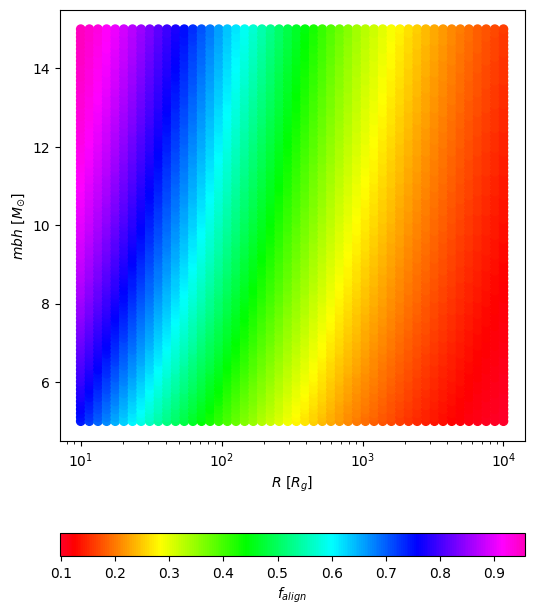

In [231]:
plt.figure(figsize=(6, 8))
plt.scatter(Rs, Ms, c=f_aligns, cmap='gist_rainbow')
plt.xscale('log')
plt.colorbar(label="$f_{align}$", orientation="horizontal")
# plt.clim(0,1)

plt.xlabel(r'$R~[R_g]$')
plt.ylabel(r'$mbh~[M_{\odot}$]')

plt.show()

In [365]:

digits=3,4,5,6,7
powers = 8, 9
alphas = 0.01, 0.1
BIMFs='Tagawa', 'Bartos', 'Vaccaro'

spin=0.9
alpha=0.1
eps=0.1
le=0.01
t_agn=10**7
MBH_digit=1

for power in powers:
    for digit in digits:
        Mbh=digit*10**(power)*ct.MSun
        R_g=Mbh * ct.G /(ct.c*ct.c)
        print(f'SMBH: {digit}e{power} MSun, 6Rg: {6*(R_g/jscript.pc):.1e} pc, {1e-4:.1e} pc')

SMBH: 3e8 MSun, 6Rg: 8.6e-05 pc, 1.0e-04 pc
SMBH: 4e8 MSun, 6Rg: 1.1e-04 pc, 1.0e-04 pc
SMBH: 5e8 MSun, 6Rg: 1.4e-04 pc, 1.0e-04 pc
SMBH: 6e8 MSun, 6Rg: 1.7e-04 pc, 1.0e-04 pc
SMBH: 7e8 MSun, 6Rg: 2.0e-04 pc, 1.0e-04 pc
SMBH: 3e9 MSun, 6Rg: 8.6e-04 pc, 1.0e-04 pc
SMBH: 4e9 MSun, 6Rg: 1.1e-03 pc, 1.0e-04 pc
SMBH: 5e9 MSun, 6Rg: 1.4e-03 pc, 1.0e-04 pc
SMBH: 6e9 MSun, 6Rg: 1.7e-03 pc, 1.0e-04 pc
SMBH: 7e9 MSun, 6Rg: 2.0e-03 pc, 1.0e-04 pc


In [421]:
digit= 1
powers = 4,5,6,7,8
alphas = 0.01, 0.1

spin=0.9
alpha=0.1
eps=0.1
le=0.01
t_agn=10**7
MBH_digit=1

if BIMF=='Vaccaro':
    mass_sec=np.genfromtxt("/Users/pmxks13/PhD/EMRIs_test/BHs_single_Zsun_rapid_nospin.dat",usecols=(0),skip_header=3,unpack=True)
elif BIMF=='Bartos':
    mass_sec=np.genfromtxt("/Users/pmxks13/PhD/EMRIs_test/BHs_Bartos_exp_2.dat",usecols=(0),skip_header=3,unpack=True)
elif BIMF=='Tagawa':
    mass_sec=np.genfromtxt("/Users/pmxks13/PhD/EMRIs_test/BHs_Tagawa_exp_2.3.dat",usecols=(0),skip_header=3,unpack=True)

for power in powers:
        Mbh=digit*10**(power)*ct.MSun
        m=10*ct.MSun
        R_g=Mbh * ct.G /(ct.c*ct.c)
        t=14e9 * ct.yr
        r = (1/(ct.c**5) * 256/5 * t * ct.G**3 * Mbh * m * (Mbh + m))**(1/4)
        print(f'SMBH: {digit}e{power} MSun, Rg: {R_g/ct.pc:.2e} pc, 1pc: {ct.pc/R_g:.2e} Rg,\nR_in: {r/R_g:.2e} Rg, {r/ct.pc:.2e} pc\n')




SMBH: 1e4 MSun, Rg: 4.79e-10 pc, 1pc: 2.09e+09 Rg,
R_in: 2.60e+04 Rg, 1.25e-05 pc

SMBH: 1e5 MSun, Rg: 4.79e-09 pc, 1pc: 2.09e+08 Rg,
R_in: 8.23e+03 Rg, 3.94e-05 pc

SMBH: 1e6 MSun, Rg: 4.79e-08 pc, 1pc: 2.09e+07 Rg,
R_in: 2.60e+03 Rg, 1.25e-04 pc

SMBH: 1e7 MSun, Rg: 4.79e-07 pc, 1pc: 2.09e+06 Rg,
R_in: 8.23e+02 Rg, 3.94e-04 pc

SMBH: 1e8 MSun, Rg: 4.79e-06 pc, 1pc: 2.09e+05 Rg,
R_in: 2.60e+02 Rg, 1.25e-03 pc



In [377]:
1e-4*ct.pc/1e3

3086000000.0

In [383]:
90860000*1e3 / ct.pc

2.944264419961115e-06

In [382]:
308600000*1e3 / ct.pc

1e-05